# Boosting - XGBoost, LightGBM, CatBoost

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import make_column_transformer
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=24)


The classification goal is predicting if the client will subscribe to a term deposit https://www.kaggle.com/datasets/rashmiranu/banking-dataset-classification 

In [2]:
data = pd.read_csv('./data/banking_train.csv')


In [3]:
data.sample(5)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
27017,27,student,married,high.school,no,yes,no,telephone,may,wed,54,1,999,0,nonexistent,no
10062,55,blue-collar,married,basic.4y,unknown,yes,yes,cellular,aug,mon,213,3,999,0,nonexistent,no
18109,33,blue-collar,divorced,basic.9y,no,no,no,cellular,jul,tue,134,1,999,0,nonexistent,no
29673,29,admin.,single,university.degree,no,no,yes,cellular,jun,thu,813,4,999,0,nonexistent,yes
14874,70,retired,married,high.school,no,yes,no,cellular,aug,tue,162,1,999,0,nonexistent,no


In [4]:
# Convert yes/no to 1/0
data['y'] = pd.Series(np.where(data['y'] == 'yes', 1, 0))
data['y'].value_counts()


0    29238
1     3712
Name: y, dtype: int64

In [5]:
def get_train_test(df):
    X, y = df.drop('y', axis=1), df['y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                        random_state=24,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test


In [6]:
X_train, X_test, y_train, y_test = get_train_test(data)
X_train.shape, X_test.shape


((26360, 15), (6590, 15))

In [7]:
feature_names = list(data.drop('y', axis=1).columns)
print(feature_names)


['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']


In [8]:
cat_feats = ['job', 'education', 'contact', 'month', 'day_of_week', 'marital', 'default', 'housing', 'loan', 'poutcome']

transformer = make_column_transformer(
    (OrdinalEncoder(), cat_feats),
    remainder='passthrough',
    verbose_feature_names_out=False
)

X_train_transform = transformer.fit_transform(X_train)
X_test_transform = transformer.transform(X_test)
print(f'X_train_transform: {X_train_transform.shape}, X_test_transform: {X_test_transform.shape}')


X_train_transform: (26360, 15), X_test_transform: (6590, 15)


In [9]:
def train_scoring(model, X_train):
    cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc'))
    return cv_score


def visual_result(model, X_train, X_test):
    print(f"roc_auc_score on cross-validation: {np.mean(cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')):.4f}")
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    print(f"roc_aus_score on test: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.4f}")
    print(classification_report(y_test, predict))
    plt.rcParams['figure.figsize'] = 7, 5
    cm = confusion_matrix(y_test, predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
    disp.plot(cmap=plt.cm.plasma);
    plt.show()


def visual_result_boosting(y_test, predict_proba, predict):
    print(f"roc_aus_score on test: {roc_auc_score(y_test, predict_proba):.4f}")
    print(classification_report(y_test, predict))
    plt.rcParams['figure.figsize'] = 7, 5
    cm = confusion_matrix(y_test, predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
    disp.plot(cmap=plt.cm.plasma);
    plt.show()


## RandomForest

In [10]:
model_rf_base = RandomForestClassifier(random_state=24)

train_scoring(model_rf_base, X_train_transform)


0.9167261554937219

roc_auc_score on cross-validation: 0.9241
roc_aus_score on test: 0.9306
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      5848
           1       0.47      0.86      0.61       742

    accuracy                           0.87      6590
   macro avg       0.72      0.87      0.77      6590
weighted avg       0.92      0.87      0.89      6590



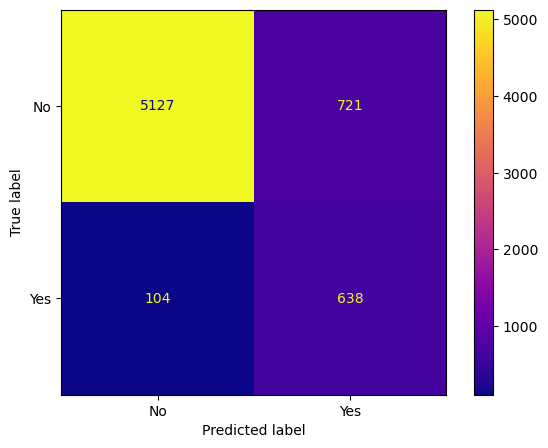

In [11]:
model_rf = RandomForestClassifier(
        class_weight='balanced',
        max_depth=15, max_features=0.6,
        min_samples_leaf=13, n_estimators=200,
        n_jobs=-1, random_state=24
    )

visual_result(model_rf, X_train_transform, X_test_transform)


## XGBoost

In [12]:
parameters = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "random_state": 24
}

model_xgb = xgb.XGBClassifier(**parameters)

train_scoring(model_xgb, X_train_transform)


0.9201932939589073

The best roc_auc_score was **0.9167** for `RandomForestClassifier` model with default parameters, which is worse then **0.9202** for `XGBClassifier` model with default parameters.

Let's try to choose parameters for better result.

In [13]:
xgb_train = xgb.DMatrix(X_train_transform, y_train,
                        feature_names=transformer.get_feature_names_out(),
                        label=y_train)
xgb_test = xgb.DMatrix(X_test_transform,
                        feature_names=transformer.get_feature_names_out(),
                        label=y_test)


In [14]:
num_rounds = 10000


In [15]:
%%time
parameters = {
    #default
    "objective": "binary:logistic",
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "eval_metric": "auc"
}

results = xgb.cv(parameters, xgb_train, num_rounds,
                 early_stopping_rounds=10,
                 folds=skf, verbose_eval=10)


[0]	train-auc:0.88366+0.00400	test-auc:0.87342+0.00591
[10]	train-auc:0.91279+0.00252	test-auc:0.89700+0.00878
[20]	train-auc:0.92831+0.00019	test-auc:0.91084+0.00503
[30]	train-auc:0.93935+0.00041	test-auc:0.91977+0.00334
[40]	train-auc:0.94504+0.00060	test-auc:0.92296+0.00316
[50]	train-auc:0.94847+0.00062	test-auc:0.92422+0.00265
[60]	train-auc:0.95107+0.00081	test-auc:0.92480+0.00229
[70]	train-auc:0.95326+0.00110	test-auc:0.92516+0.00196
[80]	train-auc:0.95570+0.00131	test-auc:0.92546+0.00187
[90]	train-auc:0.95741+0.00165	test-auc:0.92541+0.00194
[96]	train-auc:0.95866+0.00156	test-auc:0.92539+0.00195
CPU times: total: 11.1 s
Wall time: 3.32 s


In [16]:
%%time
parameters = {
    #default
    "objective": "binary:logistic",
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "eval_metric": "auc",

    #lightgbm approach
    "tree_method": "hist",
    "grow_policy": "lossguide"
}

results = xgb.cv(parameters, xgb_train, num_rounds,
                 folds=skf, early_stopping_rounds=10, verbose_eval=10)


[0]	train-auc:0.87894+0.00764	test-auc:0.86985+0.00950
[10]	train-auc:0.91245+0.00082	test-auc:0.89868+0.00633
[20]	train-auc:0.92787+0.00092	test-auc:0.91176+0.00418
[30]	train-auc:0.93935+0.00063	test-auc:0.92075+0.00419
[40]	train-auc:0.94483+0.00046	test-auc:0.92346+0.00339
[50]	train-auc:0.94837+0.00068	test-auc:0.92482+0.00280
[60]	train-auc:0.95065+0.00064	test-auc:0.92510+0.00255
[70]	train-auc:0.95264+0.00085	test-auc:0.92533+0.00240
[80]	train-auc:0.95484+0.00134	test-auc:0.92539+0.00242
[83]	train-auc:0.95554+0.00123	test-auc:0.92531+0.00251
CPU times: total: 4.5 s
Wall time: 2.39 s


In [17]:
parameters = {
    #default
    "objective": "binary:logistic",
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "eval_metric": "auc",

    #imbalanced dataset
    "scale_pos_weight": 7.87,

    #lightgbm approach
    "tree_method": "hist",
    "grow_policy": "lossguide"
}

results = xgb.cv(parameters, xgb_train, num_rounds,
                 folds=skf, early_stopping_rounds=10, verbose_eval=10)


[0]	train-auc:0.89756+0.00360	test-auc:0.88070+0.00422
[10]	train-auc:0.92602+0.00231	test-auc:0.90959+0.00406
[20]	train-auc:0.93617+0.00052	test-auc:0.91794+0.00344
[30]	train-auc:0.94211+0.00051	test-auc:0.92153+0.00275
[40]	train-auc:0.94674+0.00087	test-auc:0.92327+0.00208
[50]	train-auc:0.95088+0.00121	test-auc:0.92400+0.00207
[60]	train-auc:0.95478+0.00111	test-auc:0.92411+0.00217
[69]	train-auc:0.95765+0.00130	test-auc:0.92402+0.00200


In [18]:
parameters = {
    #default
    "objective": "binary:logistic",
    "eta": 0.3,
    "verbosity": 1,
    "seed": 24,
    "eval_metric": "auc",

    #imbalanced dataset
    "scale_pos_weight": 7.87,

    # regularization parameters
    "max_depth": 5,
    "subsample": 0.9,
    "colsample_bytree": 0.6,

    #lightgbm approach
    "tree_method": "hist",
    "grow_policy": "lossguide"
}

results = xgb.cv(parameters, xgb_train, num_rounds,
                 folds=skf, early_stopping_rounds=10, verbose_eval=10)


[0]	train-auc:0.70473+0.00422	test-auc:0.69170+0.01006
[10]	train-auc:0.93538+0.00139	test-auc:0.92346+0.00264
[20]	train-auc:0.94440+0.00124	test-auc:0.92575+0.00233
[24]	train-auc:0.94668+0.00175	test-auc:0.92510+0.00224


In [ ]:
parameters = {
    #default
    "objective": "binary:logistic",
    "eta": 0.3,
    "verbosity": 1,
    "seed": 24,
    "eval_metric": "auc",

    # regularization parameters
    "max_depth": 6,
    "max_leaves": 12,
    "subsample": 0.9,
    "colsample_bytree": 0.6,

    #imbalanced dataset
    "scale_pos_weight": 7.87,

    #lightgbm approach
    "tree_method": "hist",
    "grow_policy": "lossguide"
}

results = xgb.cv(parameters, xgb_train, num_rounds,
                 folds=skf, early_stopping_rounds=10, verbose_eval=10)


[0]	train-auc:0.71699+0.00460	test-auc:0.70984+0.00349
[10]	train-auc:0.92921+0.00115	test-auc:0.92264+0.00246
[20]	train-auc:0.93560+0.00098	test-auc:0.92585+0.00170
[30]	train-auc:0.93971+0.00105	test-auc:0.92589+0.00164
[40]	train-auc:0.94381+0.00088	test-auc:0.92536+0.00134
[41]	train-auc:0.94408+0.00082	test-auc:0.92508+0.00123


In [ ]:
parameters = {
    #default
    "objective": "binary:logistic",
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "eval_metric": "auc",

    # regularization parameters
    "max_depth": 6,
    "max_leaves": 12,
    "subsample": 0.9,
    "colsample_bytree": 0.6,

    #imbalanced dataset
    "scale_pos_weight": 7.87,

    #lightgbm approach
    "tree_method": "hist",
    "grow_policy": "lossguide"
}

results = xgb.cv(parameters, xgb_train, num_rounds,
                 folds=skf, early_stopping_rounds=20, verbose_eval=10)


[0]	train-auc:0.71699+0.00460	test-auc:0.70984+0.00349
[10]	train-auc:0.91809+0.00143	test-auc:0.91183+0.00260
[20]	train-auc:0.92559+0.00083	test-auc:0.91930+0.00242
[30]	train-auc:0.92918+0.00075	test-auc:0.92245+0.00293
[40]	train-auc:0.93143+0.00094	test-auc:0.92378+0.00272
[50]	train-auc:0.93362+0.00064	test-auc:0.92489+0.00253
[60]	train-auc:0.93560+0.00064	test-auc:0.92553+0.00253
[70]	train-auc:0.93744+0.00063	test-auc:0.92610+0.00262
[80]	train-auc:0.93887+0.00054	test-auc:0.92623+0.00250
[90]	train-auc:0.94035+0.00059	test-auc:0.92657+0.00228
[100]	train-auc:0.94185+0.00069	test-auc:0.92657+0.00225
[110]	train-auc:0.94309+0.00068	test-auc:0.92645+0.00228
[111]	train-auc:0.94321+0.00065	test-auc:0.92640+0.00231


In [ ]:
%%time
parameters = {
    #default
    "objective": "binary:logistic",
    "eta": 0.03,
    "verbosity": 1,
    "seed": 24,
    "eval_metric": "auc",

    # regularization parameters
    "max_depth": 6,
    "max_leaves": 12,
    "subsample": 0.9,
    "colsample_bytree": 0.6,

    #imbalanced dataset
    "scale_pos_weight": 7.87,

    #lightgbm approach
    "tree_method": "hist",
    "grow_policy": "lossguide"
}

results = xgb.cv(parameters, xgb_train, num_rounds,
                 folds=skf, early_stopping_rounds=20, verbose_eval=50)


[0]	train-auc:0.71699+0.00460	test-auc:0.70984+0.00349
[50]	train-auc:0.92193+0.00092	test-auc:0.91652+0.00305
[100]	train-auc:0.92843+0.00108	test-auc:0.92214+0.00258
[150]	train-auc:0.93249+0.00087	test-auc:0.92468+0.00250
[200]	train-auc:0.93598+0.00075	test-auc:0.92633+0.00232
[250]	train-auc:0.93855+0.00060	test-auc:0.92684+0.00236
[300]	train-auc:0.94081+0.00053	test-auc:0.92700+0.00236
[302]	train-auc:0.94088+0.00055	test-auc:0.92700+0.00236
CPU times: total: 10.7 s
Wall time: 6.26 s


In [ ]:
%%time
parameters = {
    #default
    "objective": "binary:logistic",
    "eta": 0.01,
    "verbosity": 1,
    "seed": 24,
    "eval_metric": "auc",

    # regularization parameters
    "max_depth": 6,
    "max_leaves": 12,
    "subsample": 0.9,
    "colsample_bytree": 0.6,

    #imbalanced dataset
    "scale_pos_weight": 7.87,

    #lightgbm approach
    "tree_method": "hist",
    "grow_policy": "lossguide"
}

results = xgb.cv(parameters, xgb_train, num_rounds,
                 folds=skf, early_stopping_rounds=30, verbose_eval=100)


[0]	train-auc:0.71699+0.00460	test-auc:0.70984+0.00349
[100]	train-auc:0.91966+0.00105	test-auc:0.91498+0.00318
[200]	train-auc:0.92491+0.00111	test-auc:0.91942+0.00289
[300]	train-auc:0.92851+0.00106	test-auc:0.92233+0.00256
[400]	train-auc:0.93147+0.00108	test-auc:0.92449+0.00234
[500]	train-auc:0.93382+0.00095	test-auc:0.92571+0.00234
[600]	train-auc:0.93557+0.00091	test-auc:0.92610+0.00221
[700]	train-auc:0.93746+0.00084	test-auc:0.92659+0.00221
[800]	train-auc:0.93927+0.00081	test-auc:0.92714+0.00218
[900]	train-auc:0.94085+0.00075	test-auc:0.92738+0.00211
[956]	train-auc:0.94166+0.00071	test-auc:0.92742+0.00217
CPU times: total: 43.6 s
Wall time: 20.3 s


In [ ]:
parameters = {
    #default
    "objective": "binary:logistic",
    "eta": 0.01,
    "verbosity": 1,
    "seed": 24,
    "eval_metric": "auc",

    # regularization parameters
    "max_depth": 6,
    "max_leaves": 12,
    "subsample": 0.9,
    "colsample_bytree": 0.6,

    #imbalanced dataset
    "scale_pos_weight": 7.87,

    #lightgbm approach
    "tree_method": "hist",
    "grow_policy": "lossguide"
}


booster = xgb.train(params=parameters, dtrain=xgb_train, num_boost_round=1000, verbose_eval=100)


roc_aus_score on test: 0.9346
              precision    recall  f1-score   support

           0       0.98      0.84      0.91      5848
           1       0.42      0.89      0.57       742

    accuracy                           0.85      6590
   macro avg       0.70      0.87      0.74      6590
weighted avg       0.92      0.85      0.87      6590



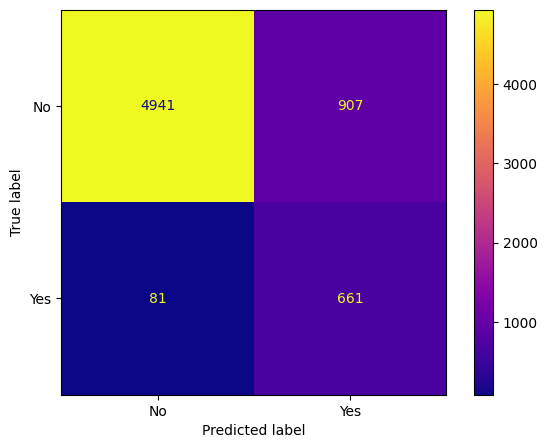

In [ ]:
predict_proba = booster.predict(xgb_test)
predict = np.where(predict_proba > 0.5, 1, 0)
visual_result_boosting(y_test, predict_proba, predict)


## LightGBM

In [19]:
lgb_train = lgb.Dataset(X_train_transform, y_train,
                        feature_name=feature_names,
                        categorical_feature=cat_feats,
                        free_raw_data=False)


In [20]:
n_rounds = 10_000


In [21]:
parameters = {
    "objective": "binary",
    "learning_rate": 0.1,
    "num_leaves": 155,
    "num_threads": 4,
    "metric": "auc",
    "seed": 24,
    "verbose": 0,
    "force_row_wise": True,
    "is_unbalance": True,
}

result = lgb.cv(
    parameters, lgb_train,
    n_rounds, folds=skf,
    eval_train_metric=True,
    callbacks=[lgb.early_stopping(10), lgb.log_evaluation(10)]
    )


d:\anaconda3\envs\projector\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	cv_agg's train auc: 0.956947 + 0.000869741	cv_agg's valid auc: 0.91454 + 0.00332366
[20]	cv_agg's train auc: 0.965249 + 0.00130758	cv_agg's valid auc: 0.917614 + 0.0038072
[30]	cv_agg's train auc: 0.974668 + 0.00102193	cv_agg's valid auc: 0.918987 + 0.00287599
[40]	cv_agg's train auc: 0.984162 + 0.000288244	cv_agg's valid auc: 0.919436 + 0.00290142
Early stopping, best iteration is:
[39]	cv_agg's train auc: 0.983357 + 0.000318903	cv_agg's valid auc: 0.919522 + 0.00277404


In [ ]:
parameters = {
    "objective": "binary",
    "learning_rate": 0.1,
    "num_leaves": 155,
    "num_threads": 4,
    "metric": "auc",
    "seed": 24,
    "verbose": 0,
    "force_row_wise": True,
    "is_unbalance": True,

    #regularization
    "colsample_bytree": 0.6,
    "subsample": 0.9,
    "subsample_freq": 1,
    "min_data_in_leaf": 25
}

result = lgb.cv(
    parameters, lgb_train,
    n_rounds, folds=skf,
    eval_train_metric=True,
    callbacks=[lgb.early_stopping(10), lgb.log_evaluation(10)]
    )


d:\machine-learning\machine_learning_projector\.venv3.9\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	cv_agg's train auc: 0.956779 + 0.00105513	cv_agg's valid auc: 0.908455 + 0.00301177
[20]	cv_agg's train auc: 0.96633 + 0.000757982	cv_agg's valid auc: 0.91564 + 0.00406332
[30]	cv_agg's train auc: 0.973318 + 0.000663447	cv_agg's valid auc: 0.918063 + 0.00377723
[40]	cv_agg's train auc: 0.980039 + 0.000376219	cv_agg's valid auc: 0.918399 + 0.00401881
Early stopping, best iteration is:
[35]	cv_agg's train auc: 0.976481 + 0.000608648	cv_agg's valid auc: 0.918649 + 0.00388615


In [ ]:
parameters = {
    "objective": "binary",
    "learning_rate": 0.1,
    "num_threads": 4,
    "metric": "auc",
    "seed": 24,
    "verbose": 0,
    "force_row_wise": True,
    "is_unbalance": True,

    "num_leaves": 50,

    #regularization
    "colsample_bytree": 0.6,
    "subsample": 0.9,
    "subsample_freq": 1,
    "min_data_in_leaf": 25
}

result = lgb.cv(
    parameters, lgb_train,
    n_rounds, folds=skf,
    eval_train_metric=True,
    callbacks=[lgb.early_stopping(10), lgb.log_evaluation(10)]
    )


d:\machine-learning\machine_learning_projector\.venv3.9\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	cv_agg's train auc: 0.938862 + 0.00177067	cv_agg's valid auc: 0.915511 + 0.0024115
[20]	cv_agg's train auc: 0.946962 + 0.0012455	cv_agg's valid auc: 0.921569 + 0.00235057
[30]	cv_agg's train auc: 0.952112 + 0.00101843	cv_agg's valid auc: 0.923361 + 0.00247123
[40]	cv_agg's train auc: 0.957066 + 0.000868888	cv_agg's valid auc: 0.923979 + 0.00233268
[50]	cv_agg's train auc: 0.961018 + 0.000739406	cv_agg's valid auc: 0.924165 + 0.00250747
[60]	cv_agg's train auc: 0.96532 + 0.000679524	cv_agg's valid auc: 0.923818 + 0.00244097
Early stopping, best iteration is:
[55]	cv_agg's train auc: 0.963309 + 0.000690897	cv_agg's valid auc: 0.924167 + 0.00235554


In [ ]:
parameters = {
    "objective": "binary",
    "learning_rate": 0.1,
    "num_threads": 4,
    "metric": "auc",
    "seed": 24,
    "verbose": 0,
    "force_row_wise": True,
    "is_unbalance": True,
    "num_leaves": 20,

    #regularization
    "colsample_bytree": 0.6,
    "subsample": 0.9,
    "subsample_freq": 1,
    "min_data_in_leaf": 25
}

result = lgb.cv(
    parameters, lgb_train,
    n_rounds, folds=skf,
    eval_train_metric=True,
    callbacks=[lgb.early_stopping(10), lgb.log_evaluation(10)]
    )


d:\machine-learning\machine_learning_projector\.venv3.9\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	cv_agg's train auc: 0.927429 + 0.0018423	cv_agg's valid auc: 0.917969 + 0.00223462
[20]	cv_agg's train auc: 0.933672 + 0.00128911	cv_agg's valid auc: 0.922952 + 0.00241848
[30]	cv_agg's train auc: 0.937507 + 0.00127139	cv_agg's valid auc: 0.924834 + 0.00254506
[40]	cv_agg's train auc: 0.940786 + 0.00120486	cv_agg's valid auc: 0.926004 + 0.00236112
[50]	cv_agg's train auc: 0.943593 + 0.00108503	cv_agg's valid auc: 0.926756 + 0.00260123
[60]	cv_agg's train auc: 0.946289 + 0.00113389	cv_agg's valid auc: 0.926776 + 0.00268824
Early stopping, best iteration is:
[55]	cv_agg's train auc: 0.945148 + 0.00111727	cv_agg's valid auc: 0.926929 + 0.00274771


In [ ]:
parameters = {
    "objective": "binary",
    "learning_rate": 0.1,
    "num_threads": 4,
    "metric": "auc",
    "seed": 24,
    "verbose": 0,
    "force_row_wise": True,
    "is_unbalance": True,
    "num_leaves": 20,
    "max_depth": 7,

    #regularization
    "colsample_bytree": 0.6,
    "subsample": 0.9,
    "subsample_freq": 1,
    "min_data_in_leaf": 25,
}

booster = lgb.train(parameters, lgb_train, num_boost_round=70)


d:\machine-learning\machine_learning_projector\.venv3.9\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


roc_aus_score on test: 0.9338
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      5848
           1       0.43      0.90      0.58       742

    accuracy                           0.85      6590
   macro avg       0.71      0.87      0.74      6590
weighted avg       0.92      0.85      0.87      6590



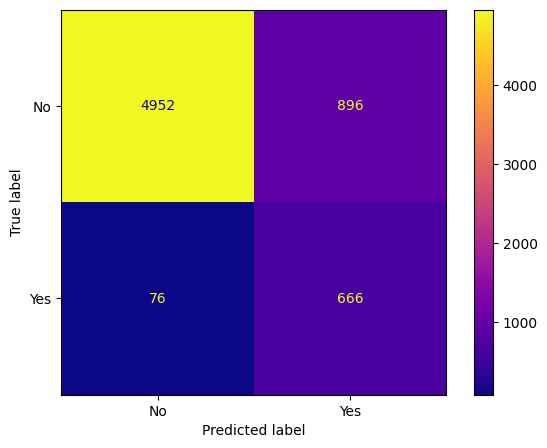

In [ ]:
predict_proba = booster.predict(X_test_transform)
predict = np.where(predict_proba>0.5, 1, 0)
visual_result_boosting(y_test, predict_proba, predict)


## CatBoost

In [22]:
cat_feats_indices = sorted([data.columns.get_loc(col) for col in cat_feats])
cat_feats_indices


[1, 2, 3, 4, 5, 6, 7, 8, 9, 14]

In [23]:
ctb_train = ctb.Pool(X_train, y_train, cat_features=cat_feats_indices)
ctb_test = ctb.Pool(X_test, cat_features=cat_feats_indices)


In [24]:
%%time
parameters_ctb = {
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "iterations": 1000,
    "learning_rate": 0.1,
    "random_seed": 24,
    "od_wait": 30,
    "od_type": "Iter",
    "thread_count": 4
}

result = ctb.cv(ctb_train, parameters_ctb, folds=skf, seed=24, verbose=False)
result.loc[result["test-AUC-mean"] == result["test-AUC-mean"].max()]


Training on fold [0/3]

bestTest = 0.9264091473
bestIteration = 256

Training on fold [1/3]

bestTest = 0.9319023245
bestIteration = 199

Training on fold [2/3]

bestTest = 0.9254205731
bestIteration = 314

CPU times: total: 2min 3s
Wall time: 45.6 s


,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
314,314,0.927774,0.003358,0.201143,0.002784,0.165972,0.00627


roc_aus_score on test: 0.9367
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      5848
           1       0.66      0.49      0.56       742

    accuracy                           0.91      6590
   macro avg       0.80      0.73      0.76      6590
weighted avg       0.91      0.91      0.91      6590



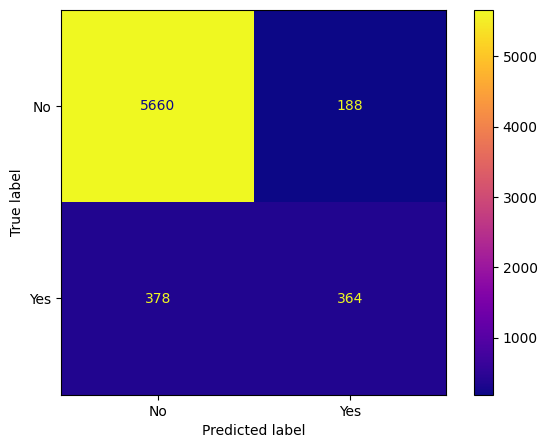

In [ ]:
parameters_ctb = {
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "iterations": 380,
    "learning_rate": 0.1,
    "random_seed": 24,
    "od_wait": 30,
    "od_type": "Iter",
    "thread_count": 4
}

model_ctb = ctb.train(ctb_train, parameters_ctb, verbose=False)
predict_proba = model_ctb.predict(ctb_test, prediction_type='Probability')[:, 1]
predict = model_ctb.predict(ctb_test, prediction_type='Class')
visual_result_boosting(y_test, predict_proba, predict)


In [ ]:
parameters_ctb = {
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "iterations": 1000,
    "learning_rate": 0.1,
    "random_seed": 24,
    "od_wait": 30,
    "od_type": "Iter",
    "thread_count": 4,

    "scale_pos_weight": 7.87
}

result = ctb.cv(ctb_train, parameters_ctb, folds=skf, seed=24, verbose=False)
result.loc[result["test-AUC-mean"] == result["test-AUC-mean"].max()]


Training on fold [0/3]

bestTest = 0.9269828592
bestIteration = 196

Training on fold [1/3]

bestTest = 0.9322158354
bestIteration = 138

Training on fold [2/3]

bestTest = 0.925339594
bestIteration = 117



,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
146,146,0.927971,0.003648,0.335187,0.009097,0.299411,0.000803


roc_aus_score on test: 0.9352
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      5848
           1       0.43      0.89      0.58       742

    accuracy                           0.85      6590
   macro avg       0.71      0.87      0.74      6590
weighted avg       0.92      0.85      0.87      6590



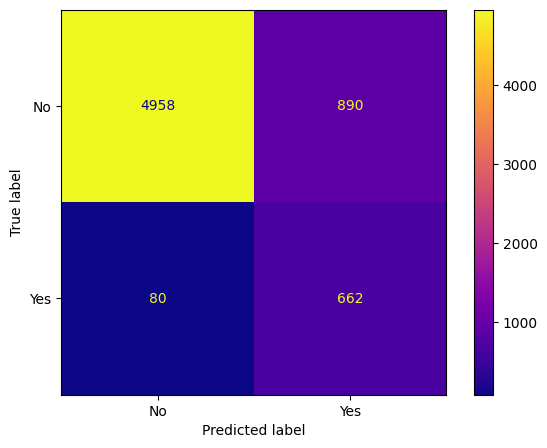

In [ ]:
parameters_ctb = {
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "iterations": 175,
    "learning_rate": 0.1,
    "random_seed": 24,
    "od_wait": 30,
    "od_type": "Iter",
    "thread_count": 4,

    "scale_pos_weight": 7.87
}

model_ctb = ctb.train(ctb_train, parameters_ctb, verbose=False)
predict_proba = model_ctb.predict(ctb_test, prediction_type='Probability')[:, 1]
predict = model_ctb.predict(ctb_test, prediction_type='Class')
visual_result_boosting(y_test, predict_proba, predict)


In [ ]:
parameters_ctb = {
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "iterations": 1000,
    "learning_rate": 0.03,
    "random_seed": 24,
    "od_wait": 30,
    "od_type": "Iter",
    "thread_count": 4,

    "scale_pos_weight": 7.87,

    "subsample": 0.9,
    "rsm": 0.6,
    "depth": 5,

}

result = ctb.cv(ctb_train, parameters_ctb, folds=skf, seed=24, verbose=False)
result.loc[result["test-AUC-mean"] == result["test-AUC-mean"].max()]


Training on fold [0/3]

bestTest = 0.9259296829
bestIteration = 758

Training on fold [1/3]

bestTest = 0.9311045559
bestIteration = 432

Training on fold [2/3]

bestTest = 0.9255550632
bestIteration = 464



,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
758,758,0.927497,0.003084,0.33709,0.007131,0.307395,0.011356


In [ ]:
parameters_ctb = {
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "iterations": 1000,
    "learning_rate": 0.03,
    "random_seed": 24,
    "od_wait": 30,
    "od_type": "Iter",
    "thread_count": 4,

    "scale_pos_weight": 7.87,

    "subsample": 0.9,
    "rsm": 0.6,
    "depth": 5,
    "l2_leaf_reg": 10
}

result = ctb.cv(ctb_train, parameters_ctb, folds=skf, seed=24, verbose=False)
result.loc[result["test-AUC-mean"] == result["test-AUC-mean"].max()]


Training on fold [0/3]

bestTest = 0.9245405187
bestIteration = 515

Training on fold [1/3]

bestTest = 0.9315977526
bestIteration = 517

Training on fold [2/3]

bestTest = 0.9261079238
bestIteration = 531



,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
531,531,0.927394,0.003706,0.337287,0.009013,0.314863,0.003441


In [ ]:
parameters_ctb = {
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "iterations": 700,
    "learning_rate": 0.03,
    "random_seed": 24,
    "od_wait": 30,
    "od_type": "Iter",
    "thread_count": 4,

    "scale_pos_weight": 7.87,

    "subsample": 0.9,
    "rsm": 0.6,
    "depth": 4,
    "l2_leaf_reg": 10,
}

result = ctb.cv(ctb_train, parameters_ctb, folds=skf, seed=24, verbose=False)
result.loc[result["test-AUC-mean"] == result["test-AUC-mean"].max()]


Training on fold [0/3]

bestTest = 0.9235490729
bestIteration = 423

Training on fold [1/3]

bestTest = 0.9309792811
bestIteration = 585

Training on fold [2/3]

bestTest = 0.9246567781
bestIteration = 586



,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
588,588,0.926379,0.004022,0.34009,0.009286,0.323184,0.002637


roc_aus_score on test: 0.9355
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      5848
           1       0.43      0.89      0.58       742

    accuracy                           0.85      6590
   macro avg       0.71      0.87      0.75      6590
weighted avg       0.92      0.85      0.87      6590



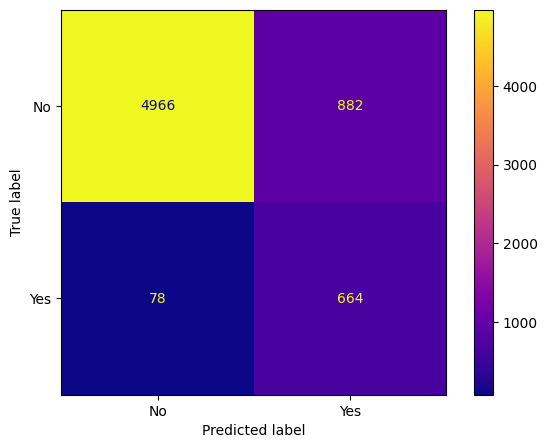

In [ ]:
parameters_ctb = {
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "iterations": 700,
    "learning_rate": 0.03,
    "random_seed": 24,
    "od_wait": 30,
    "od_type": "Iter",
    "thread_count": 4,

    "scale_pos_weight": 7.87,

    "subsample": 0.9,
    "rsm": 0.6,
    "depth": 4,
    "l2_leaf_reg": 10,
}

model_ctb = ctb.train(ctb_train, parameters_ctb, verbose=False)
predict_proba = model_ctb.predict(ctb_test, prediction_type='Probability')[:, 1]
predict = model_ctb.predict(ctb_test, prediction_type='Class')
visual_result_boosting(y_test, predict_proba, predict)


In [ ]:
parameters_ctb = {
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "iterations": 750,
    "random_seed": 24,

    "scale_pos_weight": 7.87,

}

model = ctb.CatBoostClassifier(**parameters_ctb)

grid = {'learning_rate': [0.01, 0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9, 10],
        'random_strength': [1, 2, 3, 5]}

randomized_search_result = model.randomized_search(grid,
                                                   ctb_train,
                                                   verbose=False)


0:	test: 0.8064943	best: 0.8064943 (0)	total: 44.8ms	remaining: 33.5s
1:	test: 0.8249763	best: 0.8249763 (1)	total: 85.6ms	remaining: 32s
2:	test: 0.8477862	best: 0.8477862 (2)	total: 126ms	remaining: 31.4s
3:	test: 0.8607994	best: 0.8607994 (3)	total: 168ms	remaining: 31.4s
4:	test: 0.8594070	best: 0.8607994 (3)	total: 202ms	remaining: 30.1s
5:	test: 0.8753766	best: 0.8753766 (5)	total: 243ms	remaining: 30.2s
6:	test: 0.8780692	best: 0.8780692 (6)	total: 277ms	remaining: 29.5s
7:	test: 0.8860847	best: 0.8860847 (7)	total: 331ms	remaining: 30.7s
8:	test: 0.8910804	best: 0.8910804 (8)	total: 381ms	remaining: 31.3s
9:	test: 0.8937849	best: 0.8937849 (9)	total: 434ms	remaining: 32.1s
10:	test: 0.8941561	best: 0.8941561 (10)	total: 470ms	remaining: 31.6s
11:	test: 0.8954963	best: 0.8954963 (11)	total: 516ms	remaining: 31.7s
12:	test: 0.8976277	best: 0.8976277 (12)	total: 562ms	remaining: 31.9s
13:	test: 0.8988305	best: 0.8988305 (13)	total: 610ms	remaining: 32.1s
14:	test: 0.8995169	best: 

In [ ]:
randomized_search_result['params']


{'random_strength': 5, 'depth': 10, 'l2_leaf_reg': 9, 'learning_rate': 0.03}

In [ ]:
model.get_params()


{'iterations': 750,
 'loss_function': 'Logloss',
 'random_seed': 24,
 'eval_metric': 'AUC',
 'scale_pos_weight': 7.87,
 'random_strength': 5,
 'depth': 10,
 'l2_leaf_reg': 9,
 'learning_rate': 0.03}

roc_aus_score on test: 0.9372
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      5848
           1       0.45      0.88      0.60       742

    accuracy                           0.87      6590
   macro avg       0.72      0.87      0.76      6590
weighted avg       0.92      0.87      0.88      6590



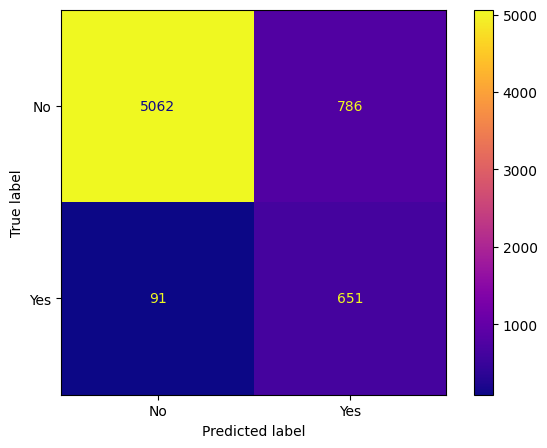

In [ ]:
predict_proba = model.predict(ctb_test, prediction_type='Probability')[:, 1]
predict = model.predict(ctb_test, prediction_type='Class')
visual_result_boosting(y_test, predict_proba, predict)


**RandomForestClassifier**:
- roc_auc_score on crossvalidation: 0.9241
- roc_auc_score on test: 0.9306

**XGBoost**:
- roc_auc_score on train: 0.9356
- roc_auc_score on test: 0.9346

**LightGBM**: 
- roc_auc_score on train: 0.9451
- roc_auc_score on test: 0.9338


**CatBoost**: 
- roc_auc_score on train: 0.9251
- roc_auc_score on test: 0.9372

